# Unusual meaning map

Source: https://www.kaggle.com/puneetsl/quora-question-pairs/unusual-meaning-map

In [2]:
import csv
import pip
import matplotlib.pylab as plt
from gensim import corpora, models, similarities
import pandas as pd
import numpy as np
train_file = "Data/train.csv"
df = pd.read_csv(train_file, index_col="id")
df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
%matplotlib inline

In [3]:
#Extracting unique questions
questions = dict()

for row in df.iterrows():
    questions[row[1]['qid1']] = row[1]['question1']
    questions[row[1]['qid2']] = row[1]['question2']


In [4]:
#Creating a simple tokenizer

import re
import nltk
def basic_cleaning(string):
    string = str(string)
    try:
        string = string.decode('unicode-escape')
    except Exception:
        pass
    string = string.lower()
    string = re.sub(' +', ' ', string)
    return string
sentences = []
for i in questions:
    sentences.append(nltk.word_tokenize(basic_cleaning(questions[i])))

In [5]:
#Creating a simple Word2Vec model from the question pair, we can use a pre-trained model instead to get better results

import gensim
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

#A very simple term frequency and document frequency extractor

tf = dict()
docf = dict()
total_docs = 0
for qid in questions:
    total_docs += 1
    toks = nltk.word_tokenize(basic_cleaning(questions[qid]))
    uniq_toks = set(toks)
    for i in toks:
        if i not in tf:
            tf[i] = 1
        else:
            tf[i] += 1
    for i in uniq_toks:
        if i not in docf:
            docf[i] = 1
        else:
            docf[i] += 1

In [6]:
#Mimic the IDF function but penalize the words which have fairly high score otherwise, and give a strong boost to the words which appear sporadically.

from __future__ import division
import math
def idf(word):
    return 1 - math.sqrt(docf[word]/total_docs)

print(idf("kenya"))

0.9907527026616816


In [7]:
#A simple cleaning module for feature extraction

import re
import nltk
def basic_cleaning(string):
    string = str(string)
    string = string.lower()
    string = re.sub('[0-9\(\)\!\^\%\$\'\"\.;,-\?\{\}\[\]\\/]', ' ', string)
    string = ' '.join([i for i in string.split() if i not in ["a", "and", "of", "the", "to", "on", "in", "at", "is"]])
    string = re.sub(' +', ' ', string)
    return string

def w2v_sim(w1, w2):
    try:
        return model.similarity(w1, w2)*idf(w1)*idf(w2)
    except Exception:
        return 0.0

Q1: I have cleared the aptitude round of Mu Sigma. On what things should I focus on to confirm my selection?
Q2: I cleared the muApt Mu Sigma. How should I prepare for the remaining rounds?
Duplicate: 0


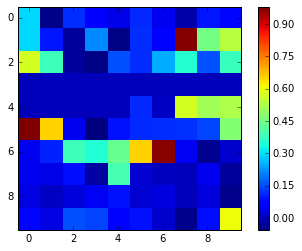

Q1: I'm gay. But I fear that one day in my fifties I'll wake up and regret not having a wife and children. What should I do?
Q2: What have you regretted telling your boyfriend/girlfriend or wife/husband?
Duplicate: 0


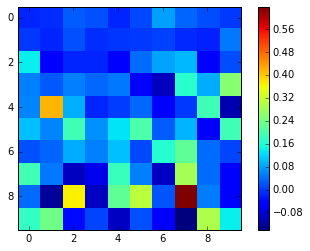

Q1: Is it theoretically possible to travel a light year in under one year due to length contraction and other relativistic effects?
Q2: What should happen if a part of your car stops working while the mechanic has it and he claims he didn't cause it?
Duplicate: 0


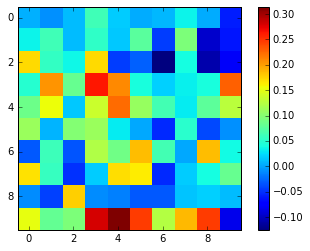

id
177499    None
197567    None
157541    None
dtype: object

In [8]:
#Visualizing features
#This function will create a 10x10 matrix using MxN word pairs among the words of question pair

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.cm as cm
from scipy import *
df = df.sample(n=30000)
def imagify(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    print("Q1: "+ s1)
    print("Q2: "+ s2)
    print("Duplicate: " + str(row['is_duplicate']))
    
    img = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(img, order='C')
    img = np.resize(a,(10,10))
    # print img
    fig = plt.figure()
    # tell imshow about color map so that only set colors are used
    image = plt.imshow(img,interpolation='nearest')
    # make a color bar
    plt.colorbar(image)
    plt.show()
s = df.sample(n=3)
plt.close()
s.apply(imagify, axis=1, raw=True)

Q1: Can you solve this maths question?
Q2: Can you solve my maths question?
Duplicate: 0


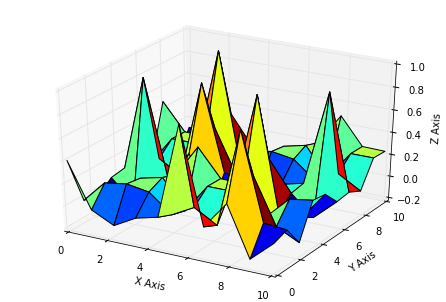

Q1: Why do people try to ask silly questions on Quora rather than googling it?
Q2: Why do so may people ask questions on Quora that can easily be found by a simple Google searh?
Duplicate: 1


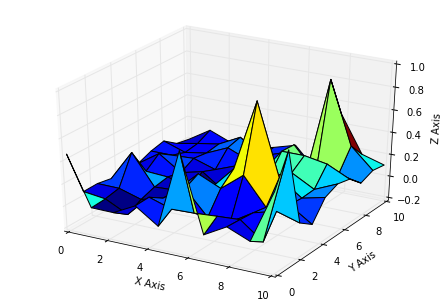

Q1: What are the Quantum numbers for oxygen?
Q2: What is a quantum number?
Duplicate: 0


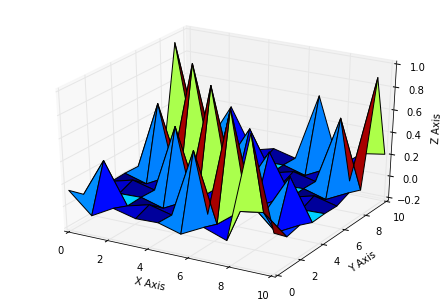

id
371304    None
278873    None
40776     None
dtype: object

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from numpy import *

plt.close()
def surface(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    print("Q1: "+ s1)
    print("Q2: "+ s2)
    print("Duplicate: " + str(row['is_duplicate']))
    
#     img = [[w2v_sim(x, y) for x in t1] for y in t2] 

    fig = plt.figure()
    ax = Axes3D(fig)
    X = linspace(0,10,10)
    Y = linspace(0,10,10)
    X, Y = meshgrid(X, Y)
    Z = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(Z, order='C')
    Z = np.resize(a,(10,10))
    
    ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=cm.jet)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    plt.show()
    
s = df.sample(n=3)
plt.close()
s.apply(surface, axis=1, raw=True)

In [10]:
def img_feature(row):
    s1 = row['question1']
    s2 = row['question2']
    t1 = list((basic_cleaning(s1)).split())
    t2 = list((basic_cleaning(s2)).split())
    Z = [[w2v_sim(x, y) for x in t1] for y in t2] 
    a = np.array(Z, order='C')
    return [np.resize(a,(10,10)).flatten()]
s = df

img = s.apply(img_feature, axis=1, raw=True)
pix_col = [[] for y in range(100)] 
for k in img.iteritems():
        for f in range(len(list(k[1][0]))):
           pix_col[f].append(k[1][0][f])

In [11]:
from nltk.corpus import stopwords
from __future__ import division
stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = df.apply(word_match_share, axis=1, raw=True)

In [12]:
from __future__ import division
x_train = pd.DataFrame()

for g in range(len(pix_col)):
    x_train['img'+str(g)] = pix_col[g]

    
x_train['word_match'] = train_word_match

y_train = s['is_duplicate'].values
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]
# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.1910486152790877


In [13]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 7

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.684261	valid-logloss:0.684507
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.611248	valid-logloss:0.614199
[20]	train-logloss:0.559146	valid-logloss:0.565004
[30]	train-logloss:0.520458	valid-logloss:0.529399
[40]	train-logloss:0.491247	valid-logloss:0.503154
[50]	train-logloss:0.468597	valid-logloss:0.483443
[60]	train-logloss:0.450471	valid-logloss:0.468276
[70]	train-logloss:0.435583	valid-logloss:0.456664
[80]	train-logloss:0.423082	valid-logloss:0.447595
[90]	train-logloss:0.412374	valid-logloss:0.440141
[100]	train-logloss:0.403199	valid-logloss:0.434242
[110]	train-logloss:0.395054	valid-logloss:0.429311
[120]	train-logloss:0.387997	valid-logloss:0.425176
[130]	train-logloss:0.381562	valid-logloss:0.421639
[140]	train-logloss:0.375214	valid-logloss:0.418381
[150]	train-logloss:0.36946	valid-logloss:0.415385
[160]	train-logloss:0.364128